##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fast Multi-Document RAG using Qdrant Binary Quantization and Gemini 2.5 Flash using LangGraph

<a target="_blank" href="https://colab.research.google.com/drive/1sgDElDo3Og0056hj81eFdBBtX2Ah7q7i?usp=sharing"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

## Overview

When building Multi-Document Retrieval-Augmented Generation (RAG) systems, speed and efficiency are paramount. However, making RAG systems truly fast and scalable, especially with large datasets and high-dimensional embeddings, remains a challenge. What if you could build a RAG system that delivers rapid responses while being incredibly memory efficient? That’s exactly what we’re going to explore by combining the usage of Qdrant’s Binary Quantization, Gemini 2.5 Flash and the orchestration capabilities of LangGraph.

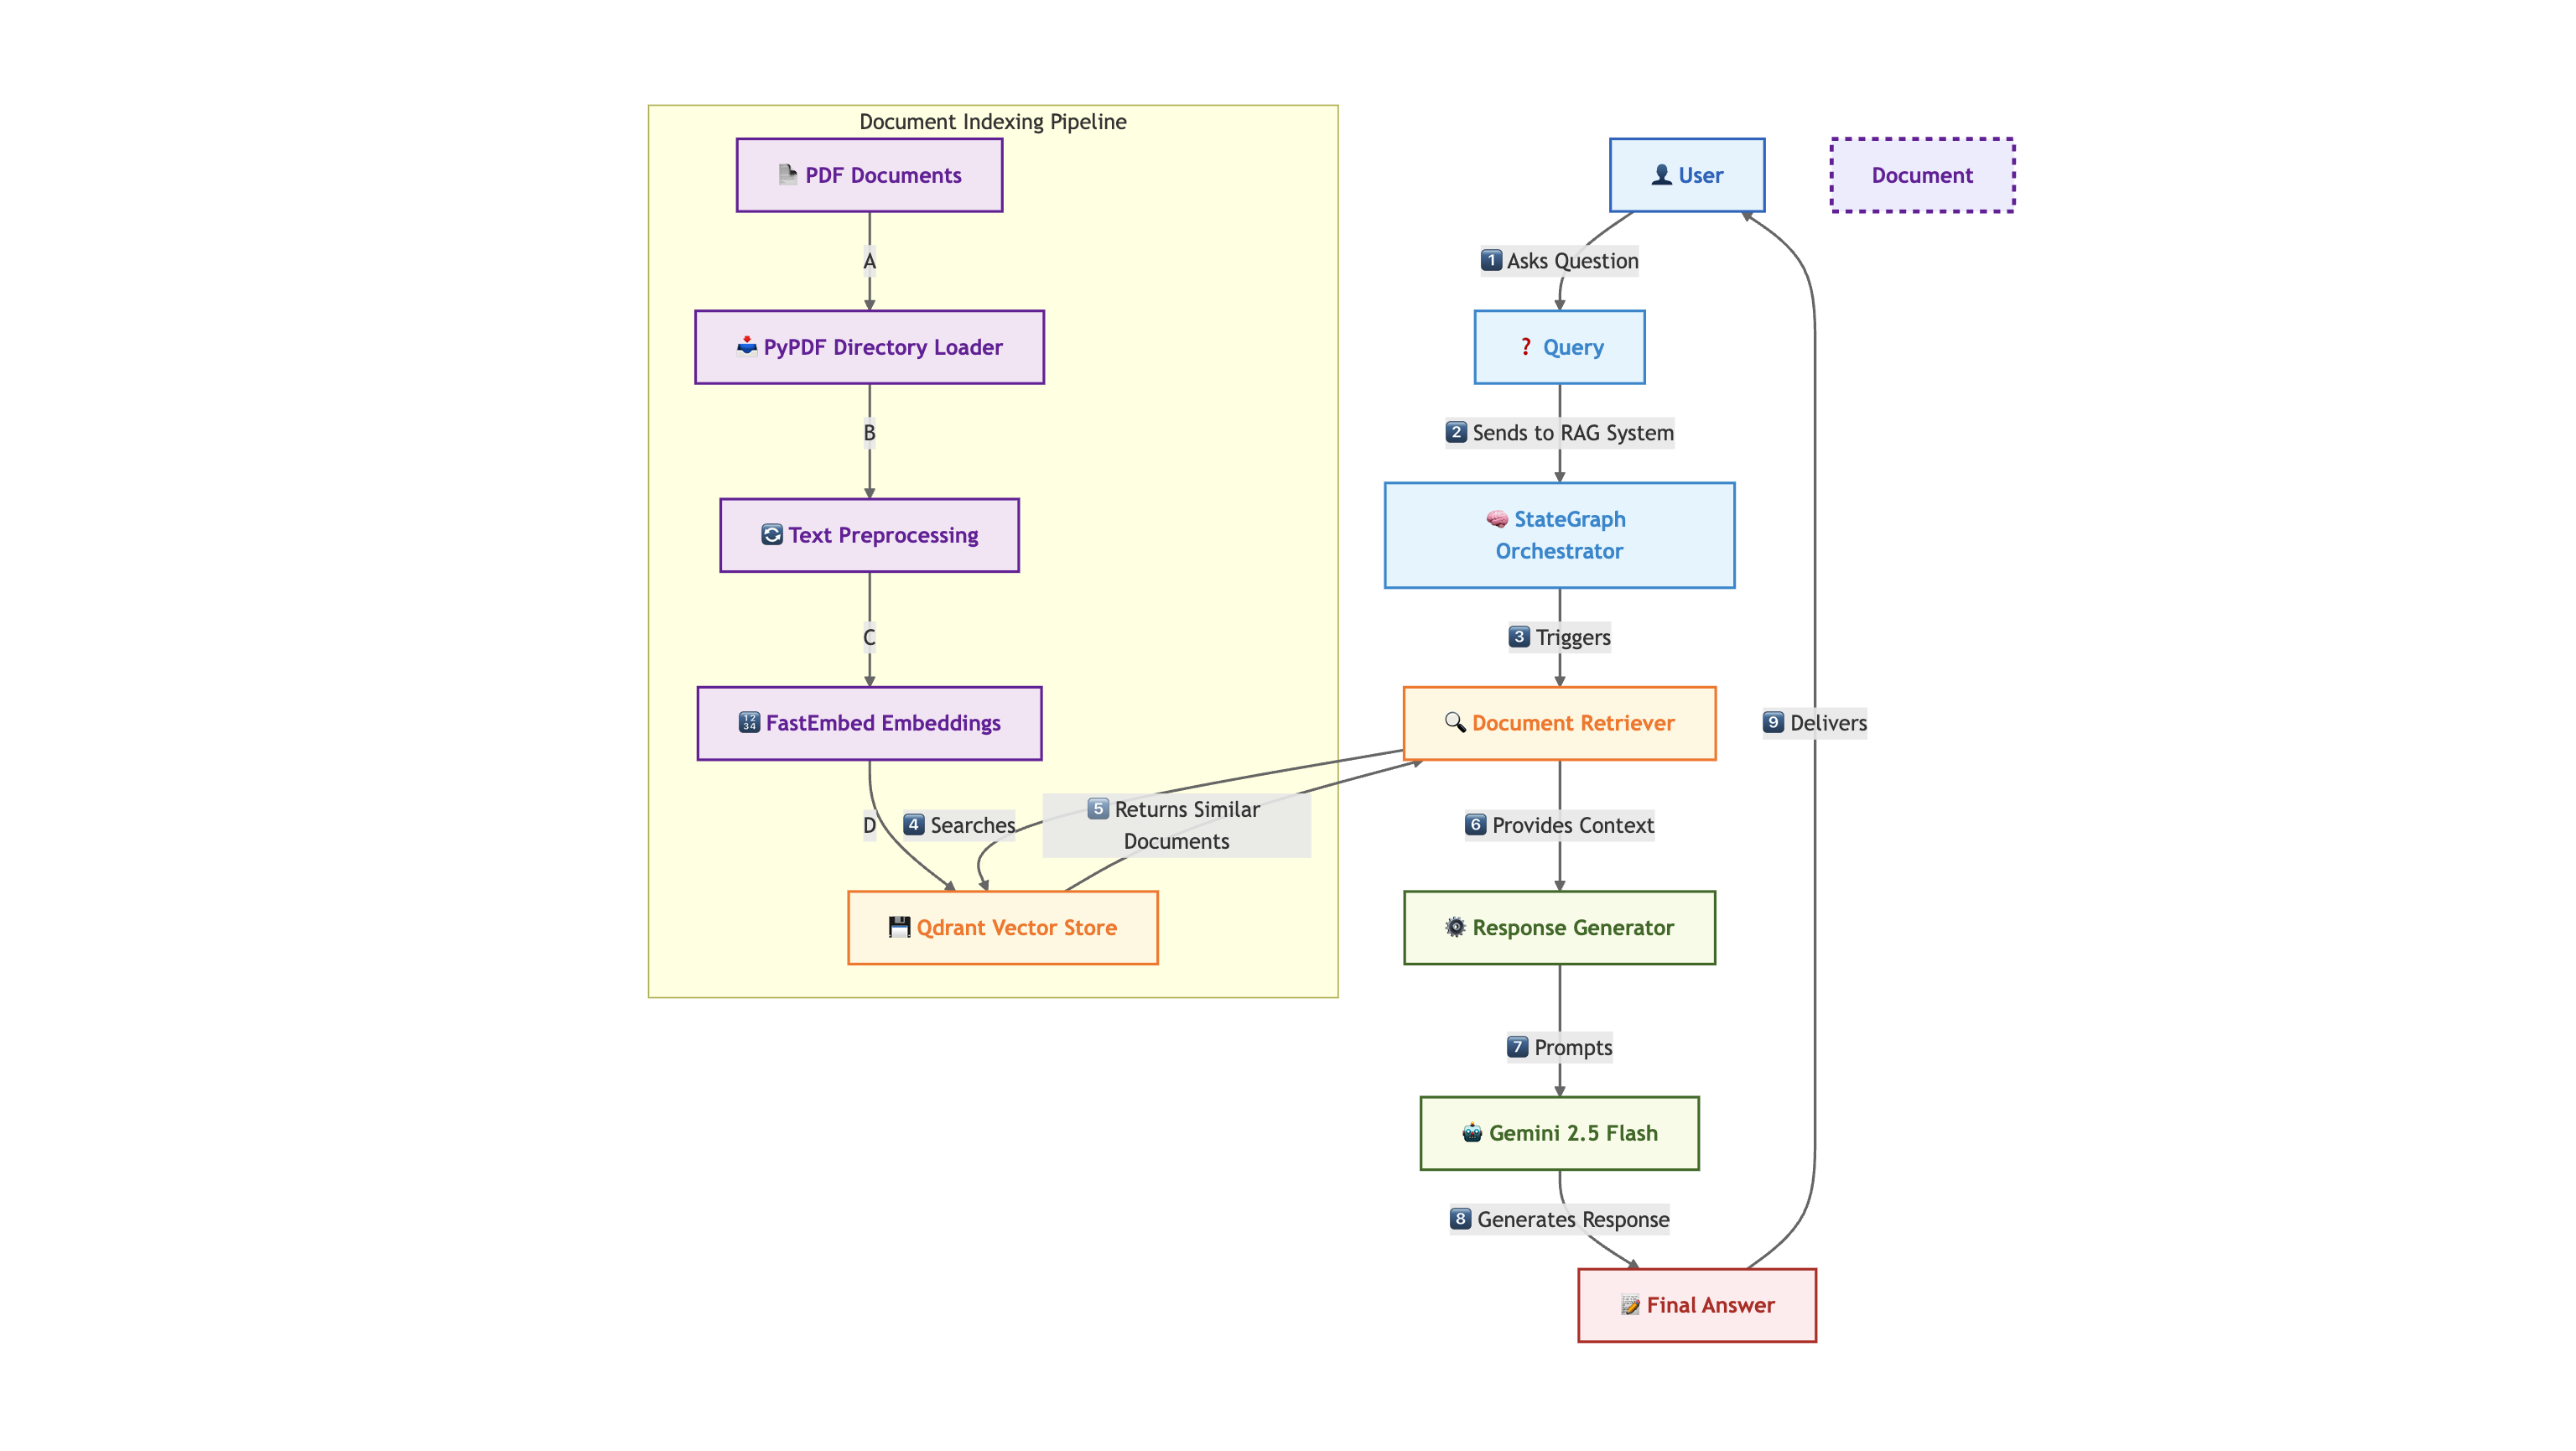

## Setup- Installation

In [ ]:
!pip install langchain langchain-community
!pip install langchain-qdrant fastembed
!pip install langchain-google-genai
!pip install langgraph
!pip install pypdf

- LangGraph: For building the Retrieval Augmented Generation pipeline
- FastEmbed: For the lightweight embeddings conversation
- Qdrant: Index the document into the Vector database and use it as retriever
- Gemini 2.5 Flash: For the LLM Inference

In [2]:
import os
from google.colab import userdata

from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import FastEmbedEmbeddings

from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client import models,http

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

## Setup - Gemini API Key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

Get your key from: [AI Studio](https://aistudio.google.com/)

In [3]:
os.environ['GOOGLE_API_KEY'] = userdata.get("GOOGLE_API_KEY")

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-preview-04-17",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

## Load your data

Create a new folder/directory named `data`, now upload multiple PDF files inside data directory.

In [6]:
loader = PyPDFDirectoryLoader(
    path = "./data/",
    glob = "**/[!.]*.pdf",
    extract_images = False,
    mode = "page",
    extraction_mode = "plain",
)

In [7]:
docs = loader.load()

In [8]:
for data_content in docs:
    data_content.page_content = data_content.page_content.replace("\n", " ")
    data_content.page_content = data_content.page_content.replace("\t", " ")

## Initialize the Qdrant Client

- `vectors_config`: Defines the main vector parameters. `size=1024` matches the embedding model we'll use. `distance=models.Distance.COSINE` specifies the similarity metric. `on_disk=True` tells Qdrant to store the full original vectors on disk instead of RAM, saving significant memory.
- `quantization_config`: This is where Binary Quantization is enabled. `models.BinaryQuantization` activates the feature. binary=models.BinaryQuantizationConfig(`always_ram=True`) Instructs Qdrant to keep the binary quantized vectors and their associated index in RAM for fastest access during the initial search phase.

In [9]:
client = QdrantClient(
    url = userdata.get("qdrant_url"),
    api_key = userdata.get("qdrant_key"),
)

### How Binary Quantization Works?

Let’s simplify the intuition behind Binary Quantization.

Imagine your original vector is a sequence of numbers, some positive, some negative, some zero. Qdrant’s Binary Quantization applies a simple rule:

- If the number is greater than zero, it becomes 1.
- If the number is zero or less than zero, it becomes 0.

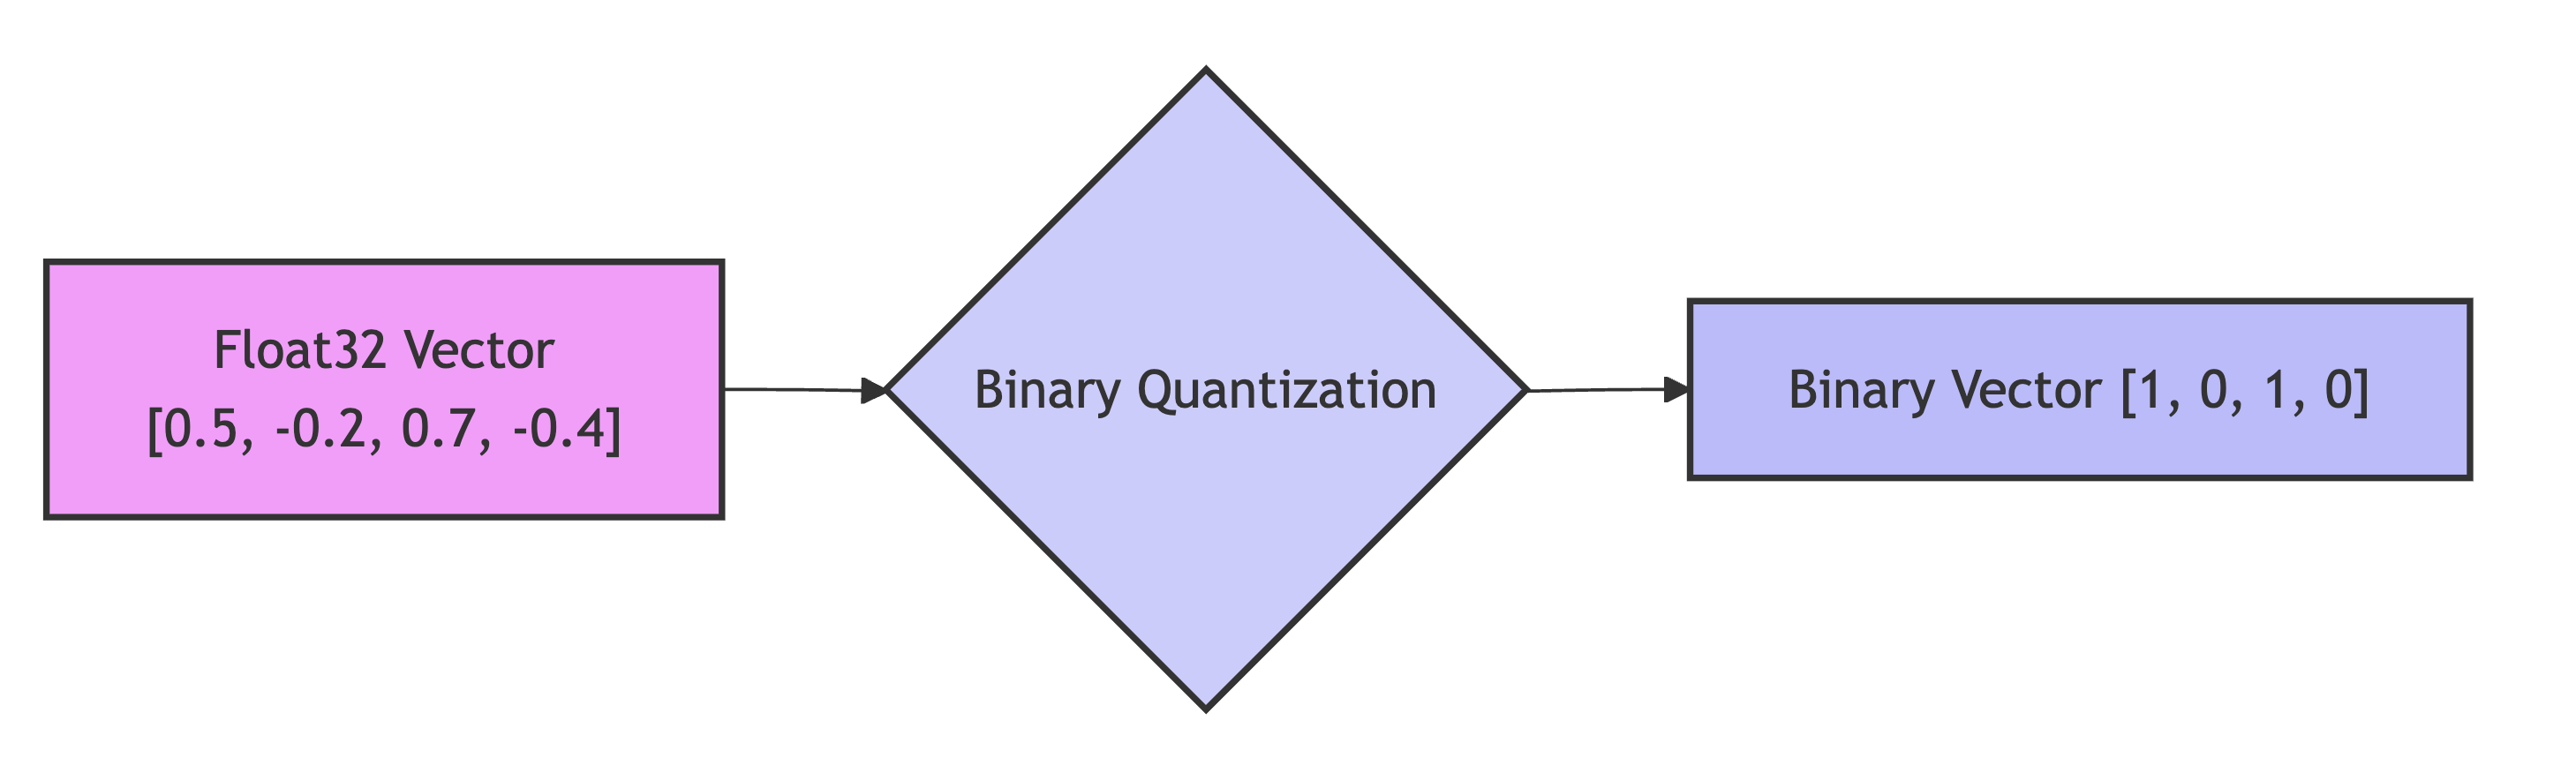

In [10]:
collection_name = "multi-document-fast-rag"
if not client.collection_exists(collection_name=collection_name):
    client.create_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(size=1024,
                                           distance=models.Distance.COSINE,on_disk=True),
        quantization_config=models.BinaryQuantization(
            binary=models.BinaryQuantizationConfig(
                always_ram=True,
            ),
        ),
    )
else:
    print("Collection already exists")

## Index your document - FastEmbed Embedding and Qdrant Vector store

We initialize the FastEmbedEmbeddings model from Qdrant. thenlper/gte-large is specified, which produces 1024-dimensional vectors, matching the size configuration in the Qdrant collection. Qdrant handles the Binary Quantization and on-disk/in-RAM placement automatically as per the collection configuration.

> Note: This might take some time to save the data

In [11]:
embeddings = FastEmbedEmbeddings(model_name="thenlper/gte-large")

/usr/local/lib/python3.11/dist-packages/langchain_community/embeddings/fastembed.py:109: UserWarning: The model thenlper/gte-large now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  values["model"] = fastembed.TextEmbedding(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [12]:
vector_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings,
)

In [ ]:
vector_store.add_documents(docs)

## Augment- Prompt Template

SYSTEM_TEMPLATE sets the persona and desired output format, including the <think> block. HUMAN_TEMPLATE structures the input provided to the LLM, including the retrieved context ``({context_str})`` and the user's question ``({query})``. It also provides instructions on how to handle out-of-context questions and asks the LLM to include source metadata.

In [14]:
SYSTEM_TEMPLATE = """
You are an expert QA Assistant who answers questions using only the provided context as your source of information. Follow these guidelines:

1. Base your answers exclusively on the information available in the context provided.
2. If the answer cannot be found in the context, clearly state "I don't have enough information in the context to answer this question."
3. Do not use prior knowledge or make assumptions beyond what is explicitly stated in the context.
4. For each answer, include relevant metadata from the context (such as source, page number, or other identifying information).
5. Present answers clearly and concisely, directly addressing the user's question.
"""

HUMAN_TEMPLATE = """
We have provided context information below.
{context_str}
---------------------
Given this information, please answer the question: {query}
---------------------
If the question is not from the provided context, say `I don't know. Not enough information received.`

Also include the Metadata i.e., the Source and page number which is added in the context
"""

## Use Vector Store as Retriever

The data I have inside the directory are the books like: 5 AM Club, Ikigai, Rich Dad Poor Dad and 3 more books. Now just to check if the retriever is working fine or not, lets ask a user question.

In [15]:
retriever = vector_store.as_retriever(search_kwargs={"k":4})

In [16]:
user_query = "how to get into the flow?"
retriever.invoke(user_query)

[Document(metadata={'producer': 'calibre 3.42.0 [https://calibre-ebook.com]', 'creator': 'calibre 3.42.0 [https://calibre-ebook.com]', 'creationdate': '2019-09-07T01:22:07+00:00', 'author': 'Héctor García & Francesc Miralles', 'title': 'Ikigai : the Japanese secret to a long and happy life - PDFDrive.com', 'source': 'data/Ikigai _ the Japanese secret to a long and happy life ( PDFDrive.com ).pdf', 'total_pages': 123, 'page': 40, 'page_label': '41', '_id': '514c2f67-7824-40de-9abb-740100c2cdb3', '_collection_name': 'multi-document-fast-rag'}, page_content='According to researcher Owen Schaffer of DePaul University, the requirements for achieving flow are: 1.  Knowing what to do 2.  Knowing how to do it 3.  Knowing how well you are doing 4.  Knowing where to go (where navigation is involved) 5.  Perceiving significant challenges 6.  Perceiving significant skills 7.  Being free from distractions 1 Strategy 1: Choose a difficult task (but not too difficult!) Schaffer’s model encourages us 

## Define RAG pipeline using LangGraph - State

StateGraph is a class that represents the graph. You initialize this class by passing in a state definition. This state definition represents a central state object that is updated over time. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store).

In [17]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [18]:
def search(state: State):
    retrieved_docs = vector_store.max_marginal_relevance_search(state["question"])
    return {"context": retrieved_docs}

In [19]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content+f"Metadata: Source-{doc.metadata['source']}+ Page: {doc.metadata['page_label']} + ID: {doc.metadata['_id']}" for doc in state["context"])
    messages = [
        {"role": "system", "content": SYSTEM_TEMPLATE},
        {"role": "user", "content": HUMAN_TEMPLATE.format(context_str=docs_content, query=state["question"])},
    ]
    response = llm.invoke(messages)
    return {"answer": response.content}

These are the node functions for the LangGraph:

- `search`: Takes the current state (which contains the question). It uses ``vector_store.max_marginal_relevance_search`` to retrieve documents. MMR (Maximal Marginal Relevance) is often preferred over simple similarity search (similarity_search) because it aims to return results that are both relevant and diverse, reducing redundancy. It updates the state with the retrieved context.
- `generate`: Takes the state (containing question and context). It formats the retrieved documents and their metadata into a single string (docs_content) suitable for the prompt. It constructs the messages list for the LLM based on the system and human templates, including the context and question.

In [20]:
graph_builder = StateGraph(State).add_sequence([search, generate])
graph_builder.add_edge(START, "search")
graph = graph_builder.compile()

## User Query from the context

In [21]:
response = graph.invoke({"question": user_query})

In [22]:
print(response["answer"])

Based on the provided context, according to researcher Owen Schaffer of DePaul University, the requirements for achieving flow are:
1. Knowing what to do
2. Knowing how to do it
3. Knowing how well you are doing
4. Knowing where to go (where navigation is involved)
5. Perceiving significant challenges
6. Perceiving significant skills
7. Being free from distractions

One strategy mentioned to get into flow is to choose a difficult task, but not too difficult. This involves taking on tasks that you have a chance of completing but are slightly outside your comfort zone. The ideal is to find a task aligned with your abilities but just a bit of a stretch, so you experience it as a challenge. This avoids boredom from tasks that are too easy and frustration from tasks that are too difficult. Examples include a graphic designer learning new software, a programmer using a new programming language, or a dancer incorporating a movement that has seemed impossible.

Metadata: Source-data/Ikigai _ t

## User Query outside the context

In [23]:
response1 = graph.invoke({"question": "who is Virat Kohli?"})

In [24]:
print(response1["answer"])

I don't have enough information in the context to answer this question.


## Summary

By strategically combining Gemini 2.5 Flash with Qdrant’s advanced Binary Quantization for highly efficient vector storage and search, and orchestrating the flow with LangGraph, we’ve built a Multi-document RAG system capable of delivering fast and memory-efficient responses.


### When should you not use BQ?

Since this method exploits the over-parameterization of embedding, you can expect poorer results for small embeddings, i.e., less than 1024 dimensions. With the smaller number of elements, there is not enough information maintained in the binary vector to achieve good results.

You will still get faster boolean operations and reduced RAM usage, but the accuracy degradation might be too high.